In [1]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pylab as plt

def plot_scores(param, paramName, tr_scores, va_scores, log_scale=False):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.plot(param, tr_scores)
    plt.plot(param, va_scores)
    plt.legend(['train', 'validation'])
    plt.xlabel(paramName)
    plt.ylabel('Accuracy')
    if log_scale:
        plt.xscale('log')
              
from hotgrad.variable import Variable
from torch import FloatTensor
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD
from torch import cat

from dataset_generator import generate_dataset

# generate the dataset
X_train, X_test, y_train, y_test = generate_dataset(1000, one_hot_encoding=True)
y_train.data = y_train.data*2-1
y_test.data = y_test.data*2-1

X_train_baselines = X_train.data.numpy()
X_test_baselines = X_test.data.numpy()
y_train_baselines = (y_train.data == 1)[:, 1].numpy()
y_test_baselines = (y_test.data == 1)[:, 1].numpy()

X_train.data = (X_train.data - X_train.data.mean())/X_train.data.std() 
X_test.data = (X_test.data - X_test.data.mean())/X_test.data.std() 

X_all = Variable(cat((X_train.data, X_test.data), 0))
y_all = Variable(cat((y_train.data, y_test.data), 0))

## Baselines: Parameters Tuning

### Logistic regression

Best lambda: 2.06913808111479
Test score: 0.594


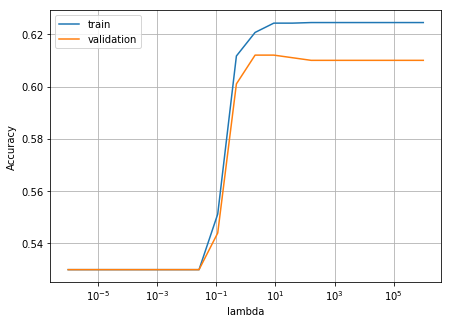

In [2]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### Random Forest

Best depth: 15
Test score: 0.967


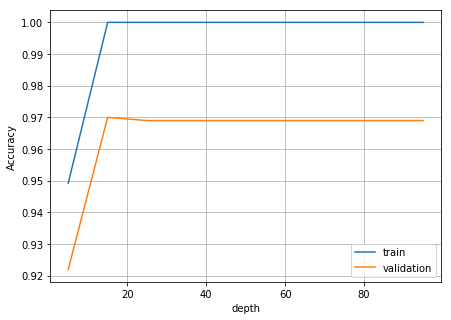

In [3]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### K-Nearest Neighbors

In [4]:
scaler = StandardScaler()
scaler.fit(X_train_baselines)
X_tr_scaled = scaler.transform(X_train_baselines)
X_te_scaled = scaler.transform(X_test_baselines)
print("standard deviation average:", X_tr_scaled.std(axis=0).mean())
print("mean average:", X_tr_scaled.mean(axis=0).mean())

standard deviation average: 0.9999995
mean average: -3.859398e-09


In [5]:
pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr_scaled = pca.transform(X_tr_scaled)
X_te_scaled = pca.transform(X_te_scaled)
X_tr_scaled.shape, X_te_scaled.shape

((1000, 2), (1000, 2))

Best k: 1
Test score: 0.973


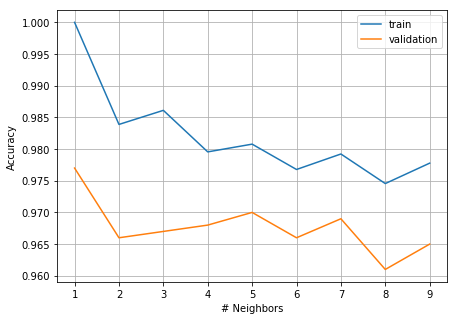

In [ ]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr_scaled, y_train_baselines, cv=10, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], log_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr_scaled, y_train_baselines)
      .score(X_te_scaled, y_test_baselines))

## Models Comparison

In [ ]:
logreg = LogisticRegression(C=best_lambda)
randforest = RandomForestClassifier(n_estimators=100, max_depth=best_depth, n_jobs=-1, random_state=1)
knn = KNeighborsClassifier(n_neighbors=best_k)

# model: two input units, two output units, three hidden layers of 25 units
# model = Sequential([Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Tanh()], MSE(), SGD(lr=0.01))
model = Sequential([Linear(25), ReLU(), Linear(25), ReLU(), Linear(25), ReLU(), Linear(2), Tanh()], MSE(), SGD(lr=0.01))

print("Running cross validation on Logistic Regression...")
logreg_scores = cross_validate(
   logreg,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on Random Forest...")
randforest_scores = cross_validate(
   randforest,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on KNearest Neighbors...")
knn_scores = cross_validate(
   knn,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on the Sequential Module...")
sequential_scores = model.cross_validate(X_all, y_all, batch_size=50, epochs=600, verbose=True, n_splits=4)

Running cross validation on Logistic Regression...
Running cross validation on Random Forest...
Running cross validation on KNearest Neighbors...
Running cross validation on the Sequential Module...
----------------- fold 1/4 -----------------
Epoch 0: Train loss: 30.83810180425644. Train accuracy 37.07%. 
Epoch 1: Train loss: 30.15571618080139. Train accuracy 42.13%. 
Epoch 2: Train loss: 30.071414530277252. Train accuracy 49.53%. 
Epoch 3: Train loss: 29.991055846214294. Train accuracy 49.53%. 
Epoch 4: Train loss: 29.911965310573578. Train accuracy 49.53%. 
Epoch 5: Train loss: 29.832969546318054. Train accuracy 49.53%. 
Epoch 6: Train loss: 29.751521408557892. Train accuracy 49.53%. 
Epoch 7: Train loss: 29.66593211889267. Train accuracy 49.53%. 
Epoch 8: Train loss: 29.57480651140213. Train accuracy 52.27%. 
Epoch 9: Train loss: 29.47630524635315. Train accuracy 56.67%. 
Epoch 10: Train loss: 29.3687744140625. Train accuracy 62.67%. 
Epoch 11: Train loss: 29.249371647834778. Train

Epoch 128: Train loss: 1.9104380123317242. Train accuracy 98.87%. 
Epoch 129: Train loss: 1.9014722015708685. Train accuracy 98.93%. 
Epoch 130: Train loss: 1.8911414723843336. Train accuracy 98.93%. 
Epoch 131: Train loss: 1.8812926728278399. Train accuracy 98.87%. 
Epoch 132: Train loss: 1.8722741585224867. Train accuracy 98.93%. 
Epoch 133: Train loss: 1.8624208895489573. Train accuracy 98.93%. 
Epoch 134: Train loss: 1.852992394939065. Train accuracy 98.93%. 
Epoch 135: Train loss: 1.8442141162231565. Train accuracy 98.93%. 
Epoch 136: Train loss: 1.8345594019629061. Train accuracy 98.93%. 
Epoch 137: Train loss: 1.8282452691346407. Train accuracy 98.93%. 
Epoch 138: Train loss: 1.8171219304203987. Train accuracy 98.93%. 
Epoch 139: Train loss: 1.808540993835777. Train accuracy 98.93%. 
Epoch 140: Train loss: 1.7989899041131139. Train accuracy 98.93%. 
Epoch 141: Train loss: 1.7912787203676999. Train accuracy 98.93%. 
Epoch 142: Train loss: 1.7832201928831637. Train accuracy 98.93%

Epoch 253: Train loss: 1.1837818165076897. Train accuracy 98.80%. 
Epoch 254: Train loss: 1.1892594636883587. Train accuracy 98.87%. 
Epoch 255: Train loss: 1.180724251200445. Train accuracy 98.80%. 
Epoch 256: Train loss: 1.1852763526840135. Train accuracy 98.80%. 
Epoch 257: Train loss: 1.173409110517241. Train accuracy 98.80%. 
Epoch 258: Train loss: 1.1759433614788577. Train accuracy 98.87%. 
Epoch 259: Train loss: 1.1711296896683052. Train accuracy 98.80%. 
Epoch 260: Train loss: 1.173711334937252. Train accuracy 98.80%. 
Epoch 261: Train loss: 1.1649544363608584. Train accuracy 98.80%. 
Epoch 262: Train loss: 1.1615707277087495. Train accuracy 98.80%. 
Epoch 263: Train loss: 1.1673398873535916. Train accuracy 98.80%. 
Epoch 264: Train loss: 1.1579668946797028. Train accuracy 98.80%. 
Epoch 265: Train loss: 1.1608001333661377. Train accuracy 98.80%. 
Epoch 266: Train loss: 1.1536803540075198. Train accuracy 98.80%. 
Epoch 267: Train loss: 1.157030531205237. Train accuracy 98.80%. 

Epoch 383: Train loss: 0.9938569924561307. Train accuracy 98.73%. 
Epoch 384: Train loss: 0.9963370449841022. Train accuracy 98.67%. 
Epoch 385: Train loss: 1.008310698729474. Train accuracy 98.67%. 
Epoch 386: Train loss: 0.9951887714560144. Train accuracy 98.73%. 
Epoch 387: Train loss: 0.9960181614733301. Train accuracy 98.67%. 
Epoch 388: Train loss: 1.0074169530998915. Train accuracy 98.67%. 
Epoch 389: Train loss: 0.9906477569020353. Train accuracy 98.67%. 
Epoch 390: Train loss: 0.9951690224115737. Train accuracy 98.67%. 
Epoch 391: Train loss: 1.0060374957392924. Train accuracy 98.67%. 
Epoch 392: Train loss: 0.9937404955271631. Train accuracy 98.67%. 
Epoch 393: Train loss: 0.9967565477127209. Train accuracy 98.67%. 
Epoch 394: Train loss: 0.9922894389019348. Train accuracy 98.67%. 
Epoch 395: Train loss: 1.0061732930480503. Train accuracy 98.67%. 
Epoch 396: Train loss: 0.994367127714213. Train accuracy 98.67%. 
Epoch 397: Train loss: 0.994465667870827. Train accuracy 98.67%.

Epoch 513: Train loss: 0.9290662547282409. Train accuracy 98.53%. 
Epoch 514: Train loss: 0.9275435023591854. Train accuracy 98.53%. 
Epoch 515: Train loss: 0.9427585290541174. Train accuracy 98.53%. 
Epoch 516: Train loss: 0.9185107037774287. Train accuracy 98.53%. 
Epoch 517: Train loss: 0.9220806877856376. Train accuracy 98.53%. 
Epoch 518: Train loss: 0.9375001287553459. Train accuracy 98.53%. 
Epoch 519: Train loss: 0.9267379024386173. Train accuracy 98.53%. 
Epoch 520: Train loss: 0.9344277477357537. Train accuracy 98.53%. 
Epoch 521: Train loss: 0.9254640656436095. Train accuracy 98.53%. 
Epoch 522: Train loss: 0.9221912553330185. Train accuracy 98.53%. 
Epoch 523: Train loss: 0.9367285193438875. Train accuracy 98.53%. 
Epoch 524: Train loss: 0.9178257653111359. Train accuracy 98.53%. 
Epoch 525: Train loss: 0.9179475814307807. Train accuracy 98.53%. 
Epoch 526: Train loss: 0.9284277548431419. Train accuracy 98.53%. 
Epoch 527: Train loss: 0.9166142152826069. Train accuracy 98.5

In [ ]:
from torch import nn
from torch import optim
from torch.autograd.variable import Variable as aVariable

X_all_pytorch_sequential = aVariable(cat((X_train.data, X_test.data), 0))
y_all_pytorch_sequential = aVariable(cat((y_train.data, y_test.data), 0))

X_train_pytorch_sequential = aVariable(X_train.data)
X_test_pytorch_sequential = aVariable(X_test.data)
y_train_pytorch_sequential = aVariable(y_train.data)
y_test_pytorch_sequential = aVariable(y_test.data)


net = nn.Sequential(nn.Linear(2,25), nn.ReLU(), nn.Linear(25,25), nn.ReLU(), nn.Linear(25,25), nn.ReLU(), nn.Linear(25,2), nn.Tanh())


In [ ]:
from pytorch.wrapper import modelWrapper

# define the network with two convolutional layers
class PytorchSequential(modelWrapper):
    def __init__(self, activation=nn.ReLU):
        super(PytorchSequential, self).__init__()
        
        self.activation = activation
        self.features = nn.Sequential(
            nn.Linear(2,25), nn.ReLU(),
            nn.Linear(25,25), nn.ReLU(),
            nn.Linear(25,25), nn.ReLU(),
            nn.Linear(25,2), nn.Tanh()
        )

        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.01)
        
    def clear(self):
        self.__init__(self.activation)
        
pytorchSequential = PytorchSequential()
sequential_scores_pytorch = pytorchSequential.cross_validate(X_all_pytorch_sequential, y_all_pytorch_sequential, batch_size=50, epochs=600, verbose=True, n_splits=4)

In [ ]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()
model_scores = [
   logreg_scores["test_score"]*100,
   randforest_scores["test_score"]*100,
   knn_scores["test_score"]*100,
   np.array(sequential_scores["test_score"])*100,
   np.array(sequential_scores_pytorch["test_score"])*100
]
model_names = [
   "Logistic Regression",
   "Random Forest",
   "KNearest Neighbors",
   "Sequential Module",
   "Pytorch Seq Module" 
]

fontdict = {'fontsize': 15 }
# 'verticalalignment': 'baseline'}

ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy", fontdict=fontdict)
ax.set_yticks(np.arange(60,101,5))
ax.set_xlabel("Model", fontdict=fontdict, labelpad=10)
plt.ylim()



_ = ax.set_xticklabels(model_names, rotation=45, fontdict=fontdict)
_ = ax.set_yticklabels(np.arange(60,101,5), fontdict=fontdict)